In [1]:
# Links:
# https://www.askpython.com/python/examples/stock-price-prediction-python
# https://www.codespeedy.com/predicting-stock-price-using-lstm-python-ml/

In [2]:
%%capture
# %%capture: Show now output for this cell
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math

!pip install keras
!pip install tensorflow
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# https://pydata.github.io/pandas-datareader/
!pip install pandas-datareader
import pandas_datareader as pdr
# pickle
import pickle

# Data importing and visualization

In [3]:
def get_stock_data(ticker_symbols, start_date, end_date = datetime.today(), date_index = True, columns="all"):
    '''
    Returns stock data from yahoo for the specified ticker symbols, start and end dates.
    A dictionary is returned and the data for each stock can be accessed by data["ticker_symbol"]
    '''
    ticker_symbols = set(ticker_symbols)
    data = {}
    for ticker in ticker_symbols:
        df = pdr.data.DataReader(ticker, 'yahoo', start = start_date, end = end_date)
        if date_index:
            if "Date" in df.columns:
                df.set_index = df["Date"]
        else:
            df["Date"] = df.index
            df.index =  range(1, df.shape[0] + 1)
        if columns != "all":
            if len(columns) > 0:
                for column in df.columns:
                    if column not in columns:
                        df = df.drop([column], axis = 1)
        if df.isnull().sum().sum() != 0:
            print(f"WARN: {df.isnull().sum().sum() } data points are missing for ticker symbol {ticker}")
        data[ticker] = df
    return data

In [4]:
def plot_data(title, df):
    '''
    '''
    ax = df.plot(title = title, fontsize = 12)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price in $")
    plt.show()

In [5]:
def tickers_as_columns(data_dict, column="Adj Close"):
    '''
    '''
    columns = []
    column_names = []
    for key in data_dict:
        column_names.append(key)
        columns.append(data_dict[key][column])
    df = pd.DataFrame(columns, index = column_names)
    return df.T

In [6]:
def get_adj_close_df(ticker_symbols, start_date, end_date = datetime.today()):
    ticker_symbols = set(ticker_symbols)
    df = pd.DataFrame()
    for ticker in ticker_symbols:
        column = pdr.data.DataReader(ticker, 'yahoo', start = start_date, end = end_date)["Adj Close"]
        column.name = ticker
        df = pd.concat([df, column], axis = 1)
   # df = pd.DataFrame(data = columns) #, columns=ticker_symbols, index = range(1, len(columns[1])))
    return df

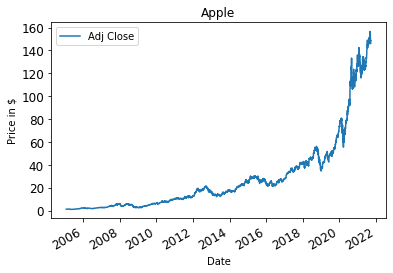

In [7]:
# Define a date range
start_date = datetime(2005, 1, 29)
end_date = datetime.today()

# Define ticker symbols
ticker_symbols = ['GOOG', "AAPL"]

# Create a dataframe with the apple stock price
apple_df = get_stock_data(ticker_symbols, start_date, end_date, columns=["Adj Close"])["AAPL"]

# Plot the data
plot_data(title="Apple" , df=apple_df)

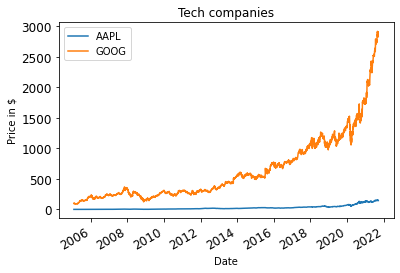

In [8]:
# Get data for multiple ticker symbols
data = get_stock_data(ticker_symbols, start_date)
formated_data = tickers_as_columns(data)

plot_data(title="Tech companies", df = formated_data)

## Functions for model training

In [9]:
def get_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True,input_shape=(input_shape,1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [23]:
def train_test_split(dataset, days = 60, train_fraction = 0.7):
    # Get the lenght of 70% of thedata
    training_data_len = math.ceil(len(dataset) * train_fraction)
    # Get the training data
    train_data = dataset[0:training_data_len  , : ]

    # Separate the data into x and y data
    x_train = []
    y_train = []
    # Iterate from day 60 to the last day of the training data
    le = len(train_data)
    for i in range(days,len(train_data)):
        # I think these commands are useless
        # x_train=list(x_train)
        # y_train=list(y_train)
        x_train.append(train_data[i-days:i,0])
        y_train.append(train_data[i,0])

    # Converting the training x and y values to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshaping training s and y data to make the calculations easier
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
 
    # Creating a dataset for testing
    test_data = dataset[training_data_len - days: , : ]
    x_test = []
    y_test =  dataset[training_data_len : , : ]
    for i in range(days,len(test_data)):
        x_test.append(test_data[i-days:i,0])

    # 2.  Convert the values into arrays for easier computation
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    
    return x_train, y_train, x_test, y_test, training_data_len

In [11]:
def print_rmse(predictions, y_test): 
    rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
    print(rmse)
    return rmse

In [12]:
def scale_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    # Scale/Normalize the data to make all values between 0 and 1
    dataset = scaler.fit_transform(data)
    return scaler, dataset

In [13]:
def rescale_data(data, scaler):
    return scaler.inverse_transform(data)

In [14]:
def make_predictions(model, data):
    predictions =  model.predict(data).reshape(-1, 1)
    return predictions

In [15]:
def plot_approximation(filtered_data, training_data_len, predictions):
    train = filtered_data[:training_data_len]
    valid = filtered_data[training_data_len:].copy()
    valid.loc[:,'Predictions'] = predictions

    plt.title('Model')
    plt.xlabel('Date')
    plt.ylabel('Close')

    plt.plot(train['GOOG'])
    plt.plot(valid[['GOOG', 'Predictions']])

    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')

    plt.show()

In [16]:
def store_model_pickle(name, model):
    try:
        model_params = model.get_params()
        fileObj = open(f'./models/{name}_params.obj', 'wb')
        pickle.dump(model_params,fileObj)
        fileObj.close()
    except:
        pass
    fileObj = open(f'{name}.obj', 'wb')
    pickle.dump(model,fileObj)
    fileObj.close()
    
def store_model_keras(name, model):
    model.save(f'./models/{name}', save_format="h5" )  # creates a HDF5 file 'my_model.h5'

In [17]:
def load_model(model_name):
    model = tf.keras.models.load_model(f"./models/{model_name}")
    return model

In [18]:
def predict_future(dataset, model, n_days = 5, days_back = 60):
    # Take the last n days from the dataset. This is the whole data needed for our prediction
    last_n_days = dataset[-days_back:]
    # Rescale that data
    scaler, scaled_data = scale_data(last_60_days)
    # Reshape so that the data can be used with our model
    scaled_data = scaled_data.reshape(1, 60, 1)
    # create new array which can hold the last 60 days and also the data to be predicted
    scaled_data_array = np.zeros((1, days_back + n_days, 1))
    # Copy the data to that new array
    for i in range(scaled_ds_last_60.shape[1]):
        scaled_data_array[0][i][0] = scaled_ds_last_60[0][i][0]
    # Iterate through the new days which should be predicted and predict them based on the existing data and the previous predictions
    for i in range(n_days):
        # from 60 + 0 to 60 + 4:
        last_60_temp = scaled_data_array[0, i : i  + days_back:, 0].reshape(1, 60 , 1)
        # print(f"Last 60_temp: {last_60_temp}")
        pred = make_predictions(first_lstm, last_60_temp)
        #  print(f"Pred.shape: {pred.shape}")
        #  print(f"Pred: {pred}")
        scaled_data_array[0, days_back + i, 0]  = pred
    
    rescaled_prediction = rescale_data(scaled_data_array.reshape(-1, 1), scaler)
    
    return rescaled_prediction[ - n_days: ,0]

In [26]:
def create_model(ticker, name, start_date, end_date = datetime.today(), pred_base_range = 60):
    # Create dictionary to store the model and its metadata
    model_dict = {}
    model_dict["name"] = name
    model_dict["ticker"] = ticker
    model_dict["start_date"] = start_date
    model_dict["end_date"] = end_date
    model_dict["pred_base_range"] = pred_base_range
    
    # Get the data, rescale it and divide it into training and test set
    df = get_adj_close_df([ticker], start_date, end_date = datetime.today())
    df_values = df.values
    scaler, scaled_dataset = scale_data(df_values)
    x_train, y_train, x_test, y_test, training_data_len = train_test_split(scaled_dataset, days = pred_base_range)
    
    # Train a model with the data
    model = get_model(input_shape = x_train.shape[1])
    model.fit(x_train, y_train, batch_size=1, epochs=1)
    model_dict["model"] = model
    return model_dict
    #store_model_keras("first_lstm", first_lstm)

In [35]:
def save_model_dict(model_dict, path):
    # First store the model using the Keras function because the model cannot be stored with pickle (weakref-error)
    store_model_keras(model_dict["name"] + "_model", model_dict["model"] )
    model_dict["model"] = None
    fileObj = open(f'{path}_metadata.obj', 'wb')
    pickle.dump(model_dict,fileObj)
    fileObj.close()

In [37]:
ABNB_model = create_model("ABNB", "AirBNB Model", start_date, end_date = datetime.today(), pred_base_range = 60)

76/76 [==============================] - 10s 102ms/step - loss: 0.0701


In [38]:
ABNB_model

{'name': 'AirBNB Model',
 'ticker': 'ABNB',
 'start_date': datetime.datetime(2005, 1, 29, 0, 0),
 'end_date': datetime.datetime(2021, 9, 18, 10, 41, 3, 871451),
 'pred_base_range': 60,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f09444708e0>}

In [39]:
save_model_dict(ABNB_model, "AirBNB")

## Preprocess the data and divide it into train and test set

In [ ]:
# This takes a subset of the dataframe which is still a dataframe with 2D (len,1)
filtered_data = formated_data.filter(['GOOG'])
# I assume this creates a Pandas Series object which is just 1D
# close_data = formated_data['GOOG']
# 2. Convert the data into array for easy evaluation
dataset = filtered_data.values

pred_base_range = 60

scaler, scaled_dataset = scale_data(dataset)
x_train, y_train, x_test, y_test, training_data_len = train_test_split(scaled_dataset, days = pred_base_range)

### Create model

In [ ]:
# first_lstm = get_model(input_shape = x_train.shape[1])
# first_lstm.fit(x_train, y_train, batch_size=1, epochs=1)
# store_model_keras("first_lstm", first_lstm)

### Load model from disk

In [ ]:
first_lstm = load_model("first_lstm")

In [ ]:
model_dict = {}
model_dict["name"] = "first_lstm"
model_dict["model"] = first_lstm
model_dict["start_date"] = start_date
model_dict["end_date"] = end_date
model_dict["ticker_symbols"] = ["GOOG"]
model_dict["pred_base_range"] =  pred_base_range

In [ ]:
test_dates = []
test_dates.append(datetime(year = 2021, month = 9, day = 15))
test_dates.append(datetime(year = 2021, month = 9, day = 17))
test_dates.append(datetime(year = 2020, month = 9, day = 17))
test_dates.append(datetime(year = 2021, month = 10, day = 17))

In [ ]:
# Making predictions on the testing data
prediction = make_predictions(first_lstm, x_test)
predictions = rescale_data(prediction, scaler)

In [ ]:
prediction.shape

In [ ]:
plot_approximation(filtered_data=filtered_data, training_data_len= training_data_len, predictions=predictions)

In [ ]:
goog_price = predict_future(dataset, first_lstm)

In [ ]:
dt1 = datetime(year = 2021, month = 9, day=20)
dt2 = datetime(year = 2021, month = 9, day=24)
dt_range  = pd.date_range(start = dt1, end = dt2)

In [ ]:
google_prediction_df = pd.DataFrame(goog_price, index = dt_range, columns = ["Predicted GOOG price"])

In [ ]:
google_prediction_df